# TODO FIX

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

import bars
import c
import signals
import u
import d

# Data Generation

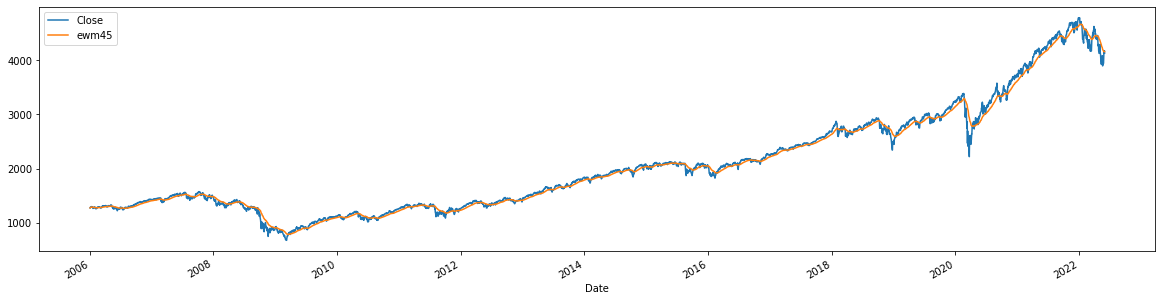

In [4]:
plt.rcParams["figure.figsize"] = (20, 5)

data = d.fetch("data/future/daily", "ES.csv")
data = data[np.datetime64("2006-01-01") :]
data["ewm45"] = data["Close"].ewm(span=45).mean()
data["Close"].plot.line()
data["ewm45"].plot.line()
plt.legend()

In [7]:
ewm45 = data["ewm45"]
curr = data["Close"]
prev = data["Close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
data["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
data["trade"] = cross_up | cross_down
data.head(10)

,Close,Open,High,Low,Volume,ewm45,dir,trade
Date,,,,,,,,
2006-01-03,1274.75,1255.25,1277.50,1251.50,1150000.0,1274.750000,0,False
2006-01-04,1280.50,1274.50,1282.25,1270.75,902220.0,1277.688889,1,True
2006-01-05,1281.25,1280.50,1283.25,1275.75,761180.0,1278.929065,0,False
2006-01-06,1291.75,1281.25,1293.00,1280.25,899360.0,1282.351075,1,True
2006-01-09,1295.00,1291.25,1297.50,1290.25,774670.0,1285.110611,0,False
2006-01-10,1296.00,1294.25,1296.75,1289.25,895510.0,1287.132999,0,False
2006-01-11,1299.75,1295.75,1301.00,1293.50,837000.0,1289.184438,0,False
2006-01-12,1293.50,1299.50,1299.75,1290.50,761250.0,1289.811435,0,False
2006-01-13,1292.75,1293.50,1295.75,1287.75,716680.0,1290.198922,0,False


# Triple Barrier

In [10]:
resampled = data.resample("M")
target = np.mean((resampled["Close"].last() / resampled["Close"].first()).std())
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(6, "M")

target

0.046356779354887356

In [11]:
indices = data.loc[data["trade"]].index

diff = np.timedelta64(30, "m")
last = indices[0]
new_indices = [last]
for i in indices:
    if last + diff < i:
        new_indices.append(i)
        last = i

indices = new_indices

barriers = signals.get_price_target_stop_loss_indices(
    data,
    indices,
    target=target,
    side=data.loc[indices, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head()

,pt_dt,sl_dt,side,vb,pt_sl,pt
2006-01-04,NaT,NaT,1,182 days 14:54:36,0,False
2006-01-06,NaT,2006-06-13,1,182 days 14:54:36,-1,False
2006-01-17,2006-06-13,NaT,-1,182 days 14:54:36,1,True
2006-01-18,2006-06-13,NaT,-1,182 days 14:54:36,1,True
2006-01-20,NaT,2006-05-05,-1,182 days 14:54:36,-1,False


In [12]:
last = barriers.index[0]
plot_indices = [last]
for i in barriers.index:
    if last + vertical_barrier < i:
        plot_indices.append(i)
        last = i

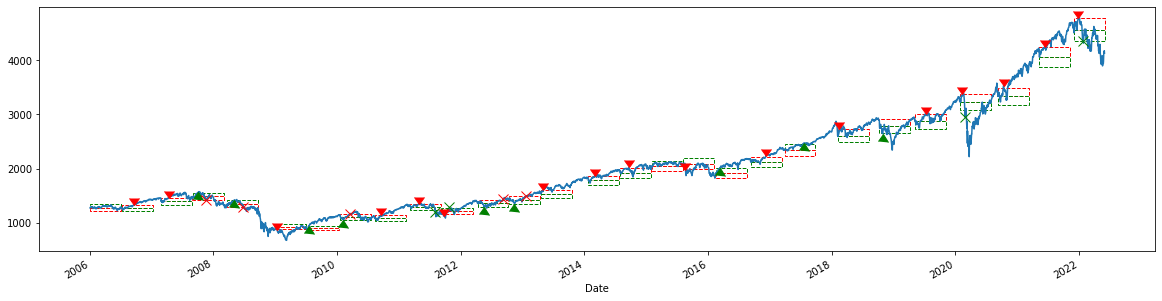

In [14]:
import plt_utils

fig, ax = plt.subplots()
data["Close"].plot.line()

plt_utils.plot_triple_barrier(
    ax,
    data,
    barriers.loc[plot_indices],
    target=target,
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)

# Classifier

In [15]:
train = barriers.merge(data, how="left", left_index=True, right_index=True)
train.head()

,pt_dt,sl_dt,side,vb,pt_sl,pt,Close,Open,High,Low,Volume,ewm45,dir,trade
2006-01-04,NaT,NaT,1,182 days 14:54:36,0,False,1280.50,1274.50,1282.25,1270.75,902220.0,1277.688889,1,True
2006-01-06,NaT,2006-06-13,1,182 days 14:54:36,-1,False,1291.75,1281.25,1293.00,1280.25,899360.0,1282.351075,1,True
2006-01-17,2006-06-13,NaT,-1,182 days 14:54:36,1,True,1289.50,1292.75,1295.25,1283.50,782530.0,1290.114244,-1,True
2006-01-18,2006-06-13,NaT,-1,182 days 14:54:36,1,True,1283.75,1286.75,1287.75,1275.25,1170000.0,1289.398764,-1,True
2006-01-20,NaT,2006-05-05,-1,182 days 14:54:36,-1,False,1264.75,1288.00,1289.25,1264.25,1590000.0,1286.848215,-1,True


In [25]:
model = RandomForestClassifier(n_estimators=100, max_depth=30)
cols = ["Close", "ewm45"]
model.fit(train[cols], train["pt"])

RandomForestClassifier(max_depth=30)

## Test

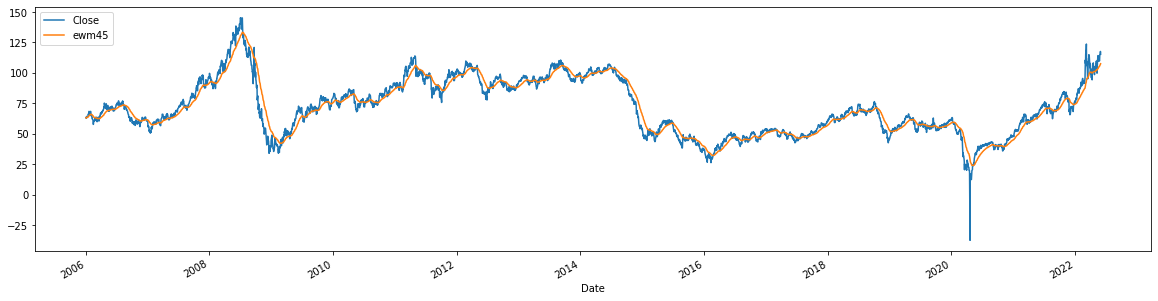

In [26]:
test = d.fetch("data/future/daily", "CL.csv")
test = test[np.datetime64("2006-01-01") :]
test["ewm45"] = test["Close"].ewm(span=45).mean()
ewm45 = test["ewm45"]
curr = test["Close"]
prev = test["Close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
test["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
test["trade"] = cross_up | cross_down
test["Close"].plot.line()
test["ewm45"].plot.line()
plt.legend()

In [22]:
pred = test.loc[test["trade"] == True].index

diff = np.timedelta64(1, "M")
last = pred[0]
new_indices = [last]
for i in pred:
    if last + diff < i:
        new_indices.append(i)
        last = i

pred = new_indices
pred = signals.get_price_target_stop_loss_indices(
    test,
    pred,
    target=target,
    side=test.loc[pred, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
pred = signals.add_profit_target_stop_loss_outcome(pred)
pred["pred"] = model.predict(test.loc[pred.index][cols])

pred.head()

,pt_dt,sl_dt,side,vb,pt_sl,pt,pred
2006-01-04,2006-01-19,2006-02-14,1,182 days 14:54:36,1,True,False
2006-03-02,2006-03-29,2006-03-08,1,182 days 14:54:36,-1,False,False
2006-05-17,2006-09-12,2006-05-30,-1,182 days 14:54:36,-1,False,False
2006-06-21,2006-06-30,2006-09-08,1,182 days 14:54:36,1,True,False
2006-08-14,2006-08-17,NaT,-1,182 days 14:54:36,1,True,False


In [23]:
info = pred.merge(test, how="left", left_index=True, right_index=True)
info.loc[info["pred"] == True].head()

,pt_dt,sl_dt,side,vb,pt_sl,pt,pred,Close,Open,High,Low,Volume,ewm45,dir,trade


<AxesSubplot:>

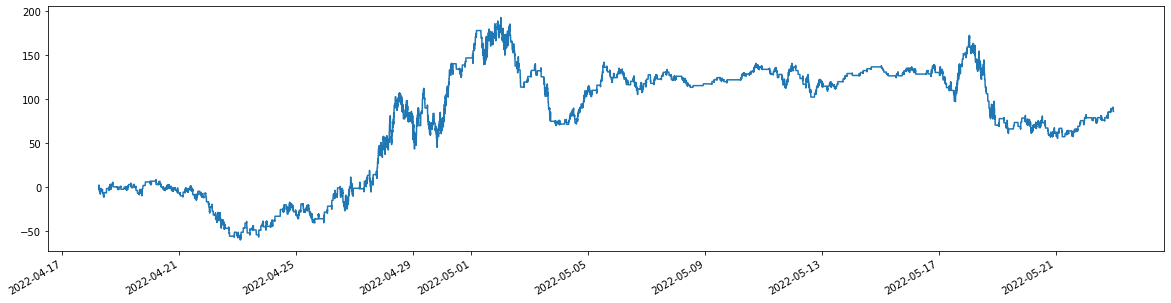

In [15]:
u_pnl = np.zeros(len(test.index))
r_pnl = np.zeros(len(test.index))
entry = None
pred_ = None
trades = 0
for e, (i, r) in enumerate(test.iterrows()):
    if entry is not None:
        if (
            i == pred_["pt_dt"]
            or i == pred_["sl_dt"]
            or i > pred_.name + vertical_barrier
        ):
            r_pnl[e] += (r["close"] - entry["close"]) * entry["dir"]
            entry = None
            pred_ = None
        else:
            u_pnl[e] = (r["close"] - entry["close"]) * entry["dir"]
    elif entry is None and r["trade"] and i in pred.index and pred.loc[i, "pred"]:
        entry = i
        entry = r
        pred_ = pred.loc[i]
        trades += 1

r_pnl = r_pnl.cumsum()
test["pnl"] = u_pnl + r_pnl
test["pnl"].plot.line()